In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import math

from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

In [2]:
# Guardar la variable imputation_lluvia_aitsu en otra variable para las modificaciones
variable = 'NIVEL_RIO_Aitzu-Urola'
data_river_2 = pd.read_csv('db_21.csv')
data_river_2 = data_river_2.set_index('Fecha')
# asignar un formato de fecha a la columna fecha
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')
imputation_lluvia_aitsu = data_river_2[[variable]].copy()

In [3]:
def analyze_duplicate_indices(df):
    # Identificar índices duplicados
    duplicated_indices = df.index[df.index.duplicated(keep=False)]
    
    if duplicated_indices.empty:
        print("No se encontraron índices duplicados.")
        return None

    # Ordenar los duplicados
    duplicates_sorted = df.loc[duplicated_indices].sort_index()

    # Agrupar los duplicados
    grouped_duplicates = duplicates_sorted.groupby(duplicates_sorted.index)

    duplicate_info = []

    for idx, group in grouped_duplicates:
        duplicate_info.append({
            'index': idx,
            'count': len(group),
            'values': group.values.flatten().tolist()
        })

    return duplicate_info

def remove_duplicate_indices(df, method='first'):
    # Analizar duplicados
    duplicate_info = analyze_duplicate_indices(df)
    
    if not duplicate_info:
        print("No hay índices duplicados para eliminar.")
        return df
    
    # Eliminar duplicados
    df_sin_duplicados = df[~df.index.duplicated(keep=method)]
    
    print(f"Se eliminaron {len(df) - len(df_sin_duplicados)} filas con índices duplicados.")
    print(f"Tamaño original del DataFrame: {len(df)}")
    print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")
    
    return df_sin_duplicados

def find_nan_sequences(df, max_consecutive_nans=120, view=False):
    nan_index = df[df.isnull().any(axis=1)].index
    # print(nan_index)
    nan_sequences = []
    
    if len(nan_index) == 0:
        return nan_sequences

    start_date = nan_index[0]
    prev_date = nan_index[0]
    
    for i in range(1, len(nan_index)):
        current_date = nan_index[i]
        
        if current_date - prev_date != pd.Timedelta('1 hour 00:00:00'):
            # No es consecutivo, guardar la secuencia anterior
            end_date = prev_date
            num_nans = (end_date - start_date).total_seconds() / 3600 + 1
            
            if num_nans == 1:
                nan_sequences.append({
                    'type': 'single',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans <= max_consecutive_nans:
                nan_sequences.append({
                    'type': 'consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans > max_consecutive_nans:
                nan_sequences.append({
                    'type': 'long_consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            else:
                if view:
                    print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
            
            # Iniciar una nueva secuencia
            start_date = current_date
        
        prev_date = current_date
    
    # Manejar la última secuencia
    end_date = prev_date
    num_nans = (end_date - start_date).total_seconds() / 3600 + 1
    
    if num_nans == 1:
        nan_sequences.append({
            'type': 'single',
            'date': start_date
        })
    elif num_nans <= max_consecutive_nans:
        nan_sequences.append({
            'type': 'consecutive',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    else:
        if view:
            print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
    
    return nan_sequences

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    
    return mse, rmse, mae, r2, mape

def plot_evaluation_metrics(metrics_list):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Métricas de Evaluación a lo largo del tiempo')
    
    for i, metric_name in enumerate(metrics_names):
        row = i // 3
        col = i % 3
        axs[row, col].plot(range(len(metrics_list)), [m[i] for m in metrics_list])
        axs[row, col].set_title(metric_name)
        axs[row, col].set_xlabel('Iteración')
        axs[row, col].set_ylabel('Valor')
    
    plt.tight_layout()
    plt.show()

def early_stopping(val_losses, patience=10):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience)):
            return True
    return False

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
def fit(model, dataloader, epoch=100):
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
        criterion = torch.nn.MSELoss()
        val_losses = []
        bar = tqdm(range(1,epoch+1))

        train_predictions = []
        val_predictions = []
        train_actuals = []
        val_actuals = []

        for epoch in bar:
            model.train()
            train_loss = []
            train_loss2 = []
            epoch_train_preds = []
            epoch_train_actuals = []

            for batch in dataloader['train']:
                X, y = batch
                X, y = X.to(device).float(), y.to(device).float()
                optimizer.zero_grad()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                train_loss2.append((y[:,-1]-y_hat[:,-1]).pow(2).mean().item())

                epoch_train_preds.append(y_hat.detach().cpu().numpy())
                epoch_train_actuals.append(y.detach().cpu().numpy())
            
            train_predictions.append(np.concatenate(epoch_train_preds))
            train_actuals.append(np.concatenate(epoch_train_actuals))

            model.eval()
            eval_loss = []
            eval_loss2 = []
            epoch_val_preds = []
            epoch_val_actuals = []

            with torch.no_grad():
                for batch in dataloader['eval']:
                    X, y = batch
                    X, y = X.to(device).float(), y.to(device).float()
                    y_hat = model(X)
                    loss = criterion(y_hat, y)
                    eval_loss.append(loss.item())
                    eval_loss2.append((y[:,-1]-y_hat[:,-1]).pow(2).mean().item())
                    epoch_val_preds.append(y_hat.detach().cpu().numpy())
                    epoch_val_actuals.append(y.detach().cpu().numpy())
            
            val_loss = np.mean(eval_loss)
            val_losses.append(val_loss)
            
            if early_stopping(val_losses):
                print(f"Early stopping at epoch {epoch}")
                break
            scheduler.step(val_loss)
            val_predictions.append(np.concatenate(epoch_val_preds))
            val_actuals.append(np.concatenate(epoch_val_actuals))

            bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

        return {
            'train_predictions': train_predictions,
            'val_predictions': val_predictions,
            'train_actuals': train_actuals,
            'val_actuals': val_actuals
        }

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device).float()
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds
    
def fit1(model, dataloader, param_grid, epochs=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = torch.nn.MSELoss()

    best_val_loss = float('inf')
    best_params = None
    best_model = None

    results = {}

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

        val_losses = []
        train_losses = []
        
        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            train_loss = []

            for batch in dataloader['train']:
                X, y = batch
                X, y = X.to(device).float(), y.to(device).float()
                optimizer.zero_grad()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss.append(loss.item())

            avg_train_loss = np.mean(train_loss)
            train_losses.append(avg_train_loss)

            model.eval()
            val_loss = []

            with torch.no_grad():
                for batch in dataloader['eval']:
                    X, y = batch
                    X, y = X.to(device).float(), y.to(device).float()
                    y_hat = model(X)
                    loss = criterion(y_hat, y)
                    val_loss.append(loss.item())

            avg_val_loss = np.mean(val_loss)
            val_losses.append(avg_val_loss)

            scheduler.step(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_params = params
                best_model = model.state_dict().copy()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
                    
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        print(f"Best validation loss: {best_val_loss}")

    # Load best model
    model.load_state_dict(best_model)
    results = {
        'model': model,
        'best_params': best_params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }

    return results

def plot_residuals(y_true, y_pred):
        residuals = y_true - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.show()

In [4]:
# Usar la función
duplicate_info = analyze_duplicate_indices(imputation_lluvia_aitsu)

# Usar la función
imputation_lluvia_aitsu_sin_duplicados = remove_duplicate_indices(imputation_lluvia_aitsu, method='first')

# Uso de la función
nan_sequences = find_nan_sequences(imputation_lluvia_aitsu_sin_duplicados, max_consecutive_nans=120, view=True)

# Imprimir resultados
for x in nan_sequences:
    print(x)

No se encontraron índices duplicados.
No se encontraron índices duplicados.
No hay índices duplicados para eliminar.
Secuencia de NaN mayor a 120 horas: 2023-10-01 00:00:00 a 2024-12-31 23:00:00, 10992.0 valores
{'type': 'long_consecutive', 'start_date': Timestamp('1999-01-01 00:00:00'), 'end_date': Timestamp('1999-03-16 16:00:00'), 'num_nans': 1793.0}
{'type': 'single', 'start_date': Timestamp('2002-01-08 00:00:00'), 'end_date': Timestamp('2002-01-08 00:00:00'), 'num_nans': 1.0}
{'type': 'consecutive', 'start_date': Timestamp('2003-02-05 12:00:00'), 'end_date': Timestamp('2003-02-05 23:00:00'), 'num_nans': 12.0}
{'type': 'single', 'start_date': Timestamp('2004-11-04 08:00:00'), 'end_date': Timestamp('2004-11-04 08:00:00'), 'num_nans': 1.0}
{'type': 'long_consecutive', 'start_date': Timestamp('2006-09-06 08:00:00'), 'end_date': Timestamp('2006-09-22 14:00:00'), 'num_nans': 391.0}
{'type': 'consecutive', 'start_date': Timestamp('2009-02-03 17:00:00'), 'end_date': Timestamp('2009-02-06 1

In [5]:
metrics_history = []
y_pred_list = []
x = 1
# Usando Pytorch
init_train = nan_sequences[0]['end_date'] + pd.Timedelta('1 hour 00:00:00')
end_train = nan_sequences[x]['start_date'] - pd.Timedelta('12000 hour 00:00:00')
data = imputation_lluvia_aitsu_sin_duplicados[init_train:end_train]
print('Fecha de inicio para el entrenamiento ----> ', data.index[0])
print('Fecha de fin del entrenamiento ------> ', data.index[-1])
# data = data[~data.index.duplicated(keep='first')]
# data = data.asfreq('H')
training_data_len = math.ceil(len(data)* 0.7)
validation_data_len = math.ceil(len(data)* 0.15)
testing_data_len = math.ceil(len(data)* 0.15)

print(data.max(), data.min())
scaler = MinMaxScaler(feature_range=(0,1))
data1 = scaler.fit_transform(data)
print(data1.max(), data1.min())

dataset_train = data1[:training_data_len][:,:1]  
dataset_val = data1[training_data_len:training_data_len + validation_data_len][:,:1]
dataset_test = data1[training_data_len + validation_data_len:][:,:1]

Fecha de inicio para el entrenamiento ---->  1999-03-16 17:00:00
Fecha de fin del entrenamiento ------>  2000-08-26 00:00:00
NIVEL_RIO_Aitzu-Urola    1.07
dtype: float64 NIVEL_RIO_Aitzu-Urola    0.051
dtype: float64
0.9999999999999999 0.0


In [8]:
# dataset_test = imputation_lluvia_aitsu_sin_duplicados[nan_sequences[x]['start_date']:nan_sequences[x]['end_date']]
# #Cambiar los valores nan por valores 0
# dataset_dataset_test = dataset_test.fillna(0) 
# print(dataset_train.shape, dataset_val.shape, dataset_test.shape)

num_values_miss = 120

# Normalizar los datos
scaler_train = scaler.transform(dataset_train)
scaler_val = scaler.transform(dataset_val)
scaler_test = scaler.transform(dataset_test)

X_train = []
y_train = []

for i in range(num_values_miss, len(scaler_train)):
    X_train.append(scaler_train[i-num_values_miss:i, 0])
    y_train.append(scaler_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print('X_train :', X_train.shape, 'y_train :', y_train.shape)

X_val = []
y_val = []

for i in range(num_values_miss, len(scaler_val)):
    X_val.append(scaler_val[i-num_values_miss:i, 0])
    y_val.append(scaler_val[i, 0])

X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0], 1))
print('X_val :', X_val.shape, 'y_val :', y_val.shape)

# X_test = X_val[X_val.shape[0]-1:X_val.shape[0]]

X_test = []
y_test = []

for i in range(num_values_miss, len(scaler_test)):
    X_test.append(scaler_test[i-num_values_miss:i, 0])
    y_test.append(scaler_test[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('X_test :', X_test.shape)
dataset_train = pd.DataFrame(dataset_train)
# print('Valores perdidos en los data sets: Train: {}, Val: {}, Test: {}'.format(dataset_train.isnull().sum().values[0], dataset_val.isnull().sum().values[0], dataset_test.isnull().sum().values[0]))

X_train : (8756, 120, 1) y_train : (8756, 1)
X_val : (1782, 120, 1) y_val : (1782, 1)
X_test : (1782, 120, 1)


/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        if self.train:
            return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
        return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_val, y_val),
    'test': TimeSeriesDataset(X_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [17]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3, output_size=1):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, h = self.lstm(x) 
        # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
        x = x[:, -1]
        # print(x.shape)
        y = self.fc(x)
        # print(y.shape)
        return y
    

lstm = LSTM()

lstm.lstm.weight_ih_l0.shape, lstm.lstm.bias_ih_l0.shape
lstm.lstm.weight_hh_l0.shape, lstm.lstm.bias_hh_l0.shape

param_grid = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'hidden_size': [64, 128, 256],
    'num_layers': [2, 1, 5]
}
results = fit1(lstm, dataloader, param_grid)


# results = fit(lstm, dataloader)


# results = fit1(lstm, dataloader, param_grid)

# # lstm.to(device)

y_pred = predict(lstm, dataloader['test'])
y_pred


Training with parameters: {'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 2}


  1%|          | 1/100 [00:00<00:59,  1.67it/s]

Epoch 1, Train Loss: 0.004359, Val Loss: 0.001143


  2%|▏         | 2/100 [00:01<00:57,  1.69it/s]

Epoch 2, Train Loss: 0.000683, Val Loss: 0.000974


  3%|▎         | 3/100 [00:01<00:59,  1.64it/s]

Epoch 3, Train Loss: 0.000531, Val Loss: 0.000793


  4%|▍         | 4/100 [00:02<00:58,  1.63it/s]

Epoch 4, Train Loss: 0.000415, Val Loss: 0.000722


  5%|▌         | 5/100 [00:03<00:56,  1.68it/s]

Epoch 5, Train Loss: 0.000382, Val Loss: 0.000599


  6%|▌         | 6/100 [00:03<00:55,  1.69it/s]

Epoch 6, Train Loss: 0.000318, Val Loss: 0.000550


  7%|▋         | 7/100 [00:04<00:54,  1.71it/s]

Epoch 7, Train Loss: 0.000295, Val Loss: 0.000487


  8%|▊         | 8/100 [00:04<00:53,  1.72it/s]

Epoch 8, Train Loss: 0.000257, Val Loss: 0.000450


  9%|▉         | 9/100 [00:05<00:55,  1.64it/s]

Epoch 9, Train Loss: 0.000248, Val Loss: 0.000447


 10%|█         | 10/100 [00:05<00:53,  1.68it/s]

Epoch 10, Train Loss: 0.000225, Val Loss: 0.000380


 11%|█         | 11/100 [00:06<00:53,  1.67it/s]

Epoch 11, Train Loss: 0.000206, Val Loss: 0.000346


 12%|█▏        | 12/100 [00:07<00:52,  1.66it/s]

Epoch 12, Train Loss: 0.000187, Val Loss: 0.000347


 13%|█▎        | 13/100 [00:07<00:51,  1.68it/s]

Epoch 13, Train Loss: 0.000177, Val Loss: 0.000336


 14%|█▍        | 14/100 [00:08<00:52,  1.65it/s]

Epoch 14, Train Loss: 0.000166, Val Loss: 0.000307


 15%|█▌        | 15/100 [00:08<00:51,  1.66it/s]

Epoch 15, Train Loss: 0.000157, Val Loss: 0.000308


 16%|█▌        | 16/100 [00:09<00:50,  1.66it/s]

Epoch 16, Train Loss: 0.000167, Val Loss: 0.000281


 17%|█▋        | 17/100 [00:10<00:49,  1.66it/s]

Epoch 17, Train Loss: 0.000162, Val Loss: 0.000286


 18%|█▊        | 18/100 [00:10<00:49,  1.64it/s]

Epoch 18, Train Loss: 0.000158, Val Loss: 0.000253


 19%|█▉        | 19/100 [00:11<00:49,  1.63it/s]

Epoch 19, Train Loss: 0.000153, Val Loss: 0.000252


 20%|██        | 20/100 [00:12<00:48,  1.65it/s]

Epoch 20, Train Loss: 0.000133, Val Loss: 0.000260


 21%|██        | 21/100 [00:12<00:47,  1.68it/s]

Epoch 21, Train Loss: 0.000150, Val Loss: 0.000244


 22%|██▏       | 22/100 [00:13<00:47,  1.65it/s]

Epoch 22, Train Loss: 0.000121, Val Loss: 0.000240


 23%|██▎       | 23/100 [00:14<00:51,  1.50it/s]

Epoch 23, Train Loss: 0.000120, Val Loss: 0.000217


 24%|██▍       | 24/100 [00:14<00:49,  1.53it/s]

Epoch 24, Train Loss: 0.000128, Val Loss: 0.000224


 25%|██▌       | 25/100 [00:15<00:48,  1.53it/s]

Epoch 25, Train Loss: 0.000123, Val Loss: 0.000225


 26%|██▌       | 26/100 [00:15<00:48,  1.53it/s]

Epoch 26, Train Loss: 0.000106, Val Loss: 0.000213


 27%|██▋       | 27/100 [00:16<00:47,  1.55it/s]

Epoch 27, Train Loss: 0.000129, Val Loss: 0.000220


 28%|██▊       | 28/100 [00:17<00:45,  1.57it/s]

Epoch 28, Train Loss: 0.000116, Val Loss: 0.000203


 29%|██▉       | 29/100 [00:17<00:44,  1.59it/s]

Epoch 29, Train Loss: 0.000103, Val Loss: 0.000212


 30%|███       | 30/100 [00:18<00:43,  1.60it/s]

Epoch 30, Train Loss: 0.000111, Val Loss: 0.000231


 31%|███       | 31/100 [00:19<00:42,  1.61it/s]

Epoch 31, Train Loss: 0.000107, Val Loss: 0.000194


 32%|███▏      | 32/100 [00:19<00:41,  1.65it/s]

Epoch 32, Train Loss: 0.000101, Val Loss: 0.000192


 33%|███▎      | 33/100 [00:20<00:41,  1.61it/s]

Epoch 33, Train Loss: 0.000101, Val Loss: 0.000226


 34%|███▍      | 34/100 [00:20<00:41,  1.60it/s]

Epoch 34, Train Loss: 0.000107, Val Loss: 0.000195


 35%|███▌      | 35/100 [00:21<00:39,  1.65it/s]

Epoch 35, Train Loss: 0.000100, Val Loss: 0.000192


 36%|███▌      | 36/100 [00:22<00:38,  1.68it/s]

Epoch 36, Train Loss: 0.000102, Val Loss: 0.000191


 37%|███▋      | 37/100 [00:22<00:37,  1.68it/s]

Epoch 37, Train Loss: 0.000101, Val Loss: 0.000195


 38%|███▊      | 38/100 [00:23<00:36,  1.69it/s]

Epoch 38, Train Loss: 0.000097, Val Loss: 0.000207


 39%|███▉      | 39/100 [00:23<00:36,  1.69it/s]

Epoch 39, Train Loss: 0.000096, Val Loss: 0.000193


 40%|████      | 40/100 [00:24<00:35,  1.71it/s]

Epoch 40, Train Loss: 0.000096, Val Loss: 0.000202


 41%|████      | 41/100 [00:25<00:35,  1.67it/s]

Epoch 41, Train Loss: 0.000088, Val Loss: 0.000184


 42%|████▏     | 42/100 [00:25<00:33,  1.72it/s]

Epoch 42, Train Loss: 0.000096, Val Loss: 0.000184


 43%|████▎     | 43/100 [00:26<00:33,  1.72it/s]

Epoch 43, Train Loss: 0.000100, Val Loss: 0.000206


 44%|████▍     | 44/100 [00:26<00:33,  1.69it/s]

Epoch 44, Train Loss: 0.000091, Val Loss: 0.000191


 45%|████▌     | 45/100 [00:27<00:32,  1.67it/s]

Epoch 45, Train Loss: 0.000094, Val Loss: 0.000190


 46%|████▌     | 46/100 [00:27<00:32,  1.66it/s]

Epoch 46, Train Loss: 0.000092, Val Loss: 0.000205


 47%|████▋     | 47/100 [00:28<00:32,  1.64it/s]

Epoch 47, Train Loss: 0.000096, Val Loss: 0.000206


 48%|████▊     | 48/100 [00:29<00:31,  1.64it/s]

Epoch 48, Train Loss: 0.000082, Val Loss: 0.000188


 49%|████▉     | 49/100 [00:29<00:30,  1.66it/s]

Epoch 49, Train Loss: 0.000081, Val Loss: 0.000189


 50%|█████     | 50/100 [00:30<00:29,  1.69it/s]

Epoch 50, Train Loss: 0.000090, Val Loss: 0.000197


 50%|█████     | 50/100 [00:30<00:30,  1.61it/s]


Early stopping at epoch 51
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 64, 'learning_rate': 1e-05, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 128, 'learning_rate': 1e-05, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_layers': 2}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_layers': 1}


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping at epoch 1
Best validation loss: 0.00018360634034511998
Training with parameters: {'hidden_size': 256, 'learning_rate': 1e-05, 'num_layers': 5}


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 1
Best validation loss: 0.00018360634034511998


tensor([[-0.0246],
        [-0.0246],
        [-0.0245],
        ...,
        [-0.0248],
        [-0.0248],
        [-0.0248]], device='cuda:0')

In [14]:
# X = X_test
# print(X.shape)
# for step_ahead in range(len(dataset_test)):
#     inputs = torch.from_numpy(X[:,step_ahead:]).unsqueeze(0) # Con este iterable (step_ahead:) se va desplazando la ventana de tiempo desde el numero actual de valores hasta el final de numeros que deseo predecir
#     y_pred_one = predict(lstm, inputs).cpu().numpy()
#     y_pred_list.append(y_pred_one)
#     X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
#     print(X.shape)

# y_pred = X[:, -dataset_test.isnull().sum().values[0]:, -1]
# y_RNN_O_test = scaler.inverse_transform(y_pred) 
# # y_RNN_O_test = y_RNN_O_test.reshape(-1,1)
# y_RNN_O_test = y_RNN_O_test[y_RNN_O_test.shape[1]-1:y_RNN_O_test.shape[1]] 

train_preds = scaler.inverse_transform(results['train_predictions'][-1])
val_preds = scaler.inverse_transform(results['val_predictions'][-1])
train_actuals = scaler.inverse_transform(results['train_actuals'][-1])
val_actuals = scaler.inverse_transform(results['val_actuals'][-1])

mse, rmse, mae, r2, mape = calculate_metrics(val_actuals.flatten(), val_preds.flatten())
metrics_history.append((mse, rmse, mae, r2, mape))

In [15]:
# Crear índices de fecha para las predicciones
train_dates = dataset_train.index[-len(train_preds):]
val_dates = dataset_val.index[-len(val_preds):]

#Obtener el primer indice de dataset_test
date = dataset_test[len(dataset_test)-y_pred.shape[0]:].index
date = date.to_numpy().reshape(-1, 1)
fig, ax = plt.subplots(1,figsize=(25, 10), sharex=True, sharey=True)
fig.suptitle('Comparacion de los modelos RNN, LSTM y GRU')

# predictions_df = pd.DataFrame(y_RNN_O_test, index=date.flatten(), columns=[variable])
# predictions_df = predictions_df.loc[~predictions_df.index.duplicated(keep='first')]
# print("Fecha de inicio para la actualizacion de los datos: ", predictions_df.index[0])
# print("Fecha de fin para la actualizacion de los datos: ", predictions_df.index[-1])

ax.plot(dataset_train.index, dataset_train, label = 'Train', color = 'blue')
ax.plot(dataset_val.index, dataset_val, color = 'g', label = 'Val')
# ax.plot(train_dates[:len(train_preds)], train_preds, color='lightblue', label='Predicción Entrenamiento', linestyle='--')
# ax.plot(train_dates, train_preds, color='lightblue', label='Predicción Entrenamiento', linestyle='--')
# Graficar predicciones de validación
ax.plot(val_dates, val_preds, color='brown', label='Predicción Validación', linewidth=2)
ax.plot(dataset_test.index, dataset_test, color='g', label=' Real Test', linewidth=2)  
ax.plot(date, y_pred.flatten().cpu(), color='red', label='Predicción Test', linewidth=2)
ax.legend()
ax.set_title('Basic RNN')  

plt.xlabel('Fecha')
plt.ylabel('Nivel del rio')
plt.show() 

NameError: name 'train_preds' is not defined

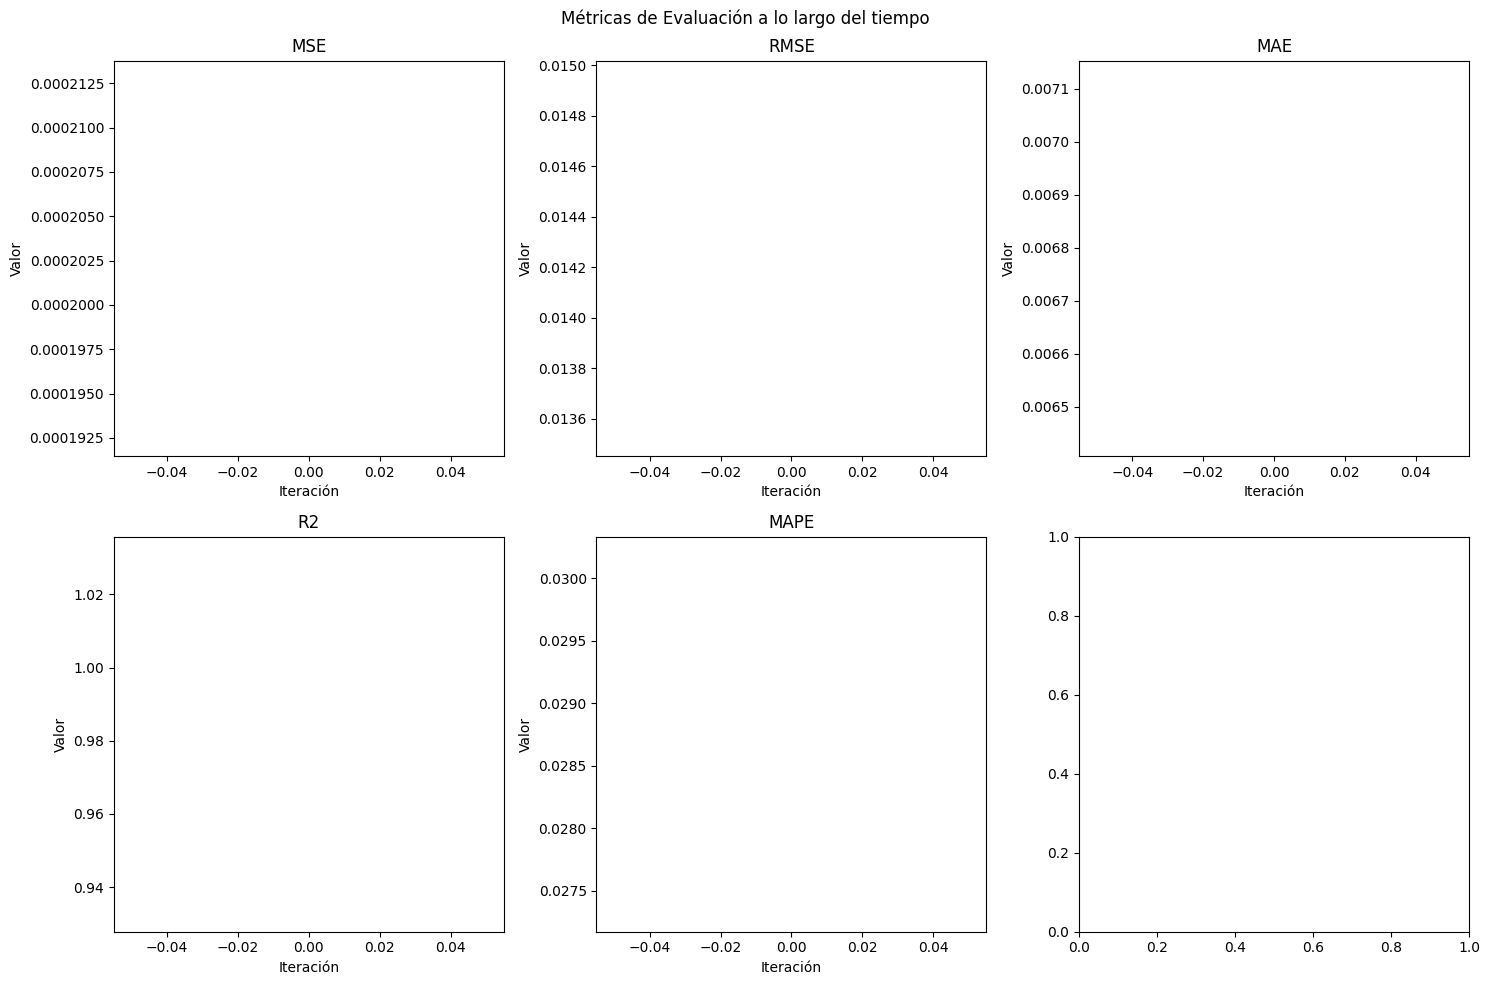

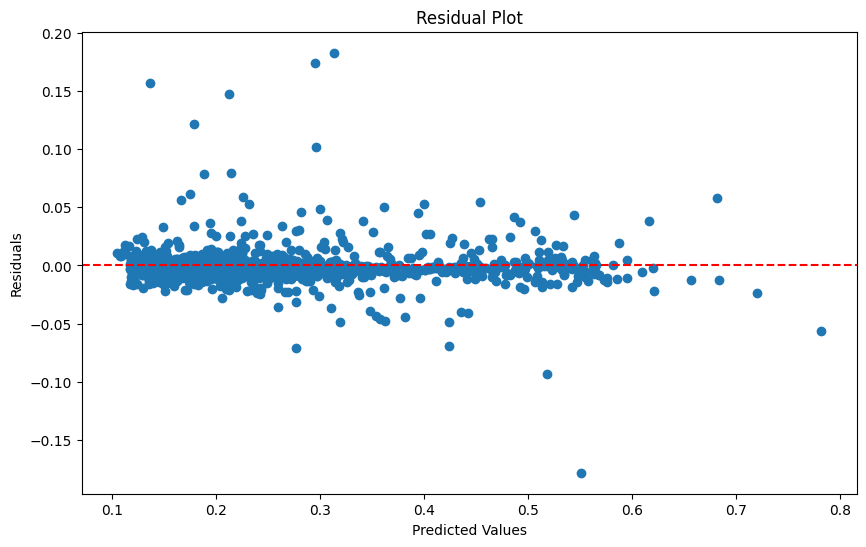

MSE: 0.0304
RMSE: 0.1745
MAE: 0.1700
R2 Score: -18.4186
MAPE: 1.2149

Evaluación final del modelo:
MSE final: 0.0304
RMSE final: 0.1745
MAE final: 0.1700
R2 Score final: -18.4186
MAPE final: 1.2149


In [ ]:
plot_evaluation_metrics(metrics_history)

# Para el conjunto de validación
plot_residuals(val_actuals, val_preds)

# print(imputation_lluvia_aitsu[nan_sequences[x]['start_date']:nan_sequences[x]['end_date']])

# imputation_lluvia_aitsu.update(predictions_df)
# imputation_lluvia_aitsu.describe()
# imputation_lluvia_aitsu_sin_duplicados.update(predictions_df)
# imputation_lluvia_aitsu_sin_duplicados.describe()


# print(imputation_lluvia_aitsu_sin_duplicados[nan_sequences[x]['start_date']:nan_sequences[x]['end_date']])
a = dataset_test.values[120:]
final_metrics = calculate_metrics(a, y_pred.flatten().cpu().numpy())

print("\nEvaluación final del modelo:")
print(f"MSE final: {final_metrics[0]:.4f}")
print(f"RMSE final: {final_metrics[1]:.4f}")
print(f"MAE final: {final_metrics[2]:.4f}")
print(f"R2 Score final: {final_metrics[3]:.4f}")
print(f"MAPE final: {final_metrics[4]:.4f}")

# # Graficar comparación final
# plt.figure(figsize=(15, 6))
# plt.plot(imputation_lluvia_aitsu_sin_duplicados.index, imputation_lluvia_aitsu_sin_duplicados.values, label='Predicciones', color='red')
# plt.plot(imputation_lluvia_aitsu.index, imputation_lluvia_aitsu.values, label='Valores Reales', color='blue')
# plt.title('Comparación Final: Predicciones vs Valores Reales')
# plt.xlabel('Fecha')
# plt.ylabel('Nivel del Río')
# plt.legend()
# plt.show()